# Threshold EDA then Following the Rabbit Down the Rabbit Hole

The idea there is to start simple by reviewing the thresholds, and then just start following the data and some interesting finds to see where things lead ..

(the title is in reference to Alice in Wonderland where alice follows the rabbit down the rabbit hole, in a sense we're going to follow the data and see where it leads us). 

Let's get going :-)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv']


# Imports

In [2]:
# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
# Garbage Collector
import gc
import sys
# Stats
from scipy import stats
# Text analysis
from fuzzywuzzy import fuzz

# Load Data

In [3]:
# load training data
j_df = pd.read_csv("../input/train.csv")

# Data View

let's get a quick look at the data to familiarize ourselves

In [4]:
j_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


# Target Histogram

Let's start simple.  I think in a lot of ways everyone wants to dominate the world right off the bat, let's not do that, let's start simple and see where things lead.

## Including 0's

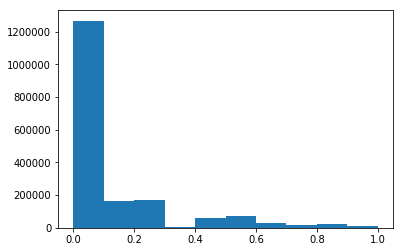

In [5]:
plt.hist(j_df['target'])
plt.show()

clearly we have a bunch of 0's, as expected, but they're really distroying our view here, so let's get rid of them.

## Excluding 0's

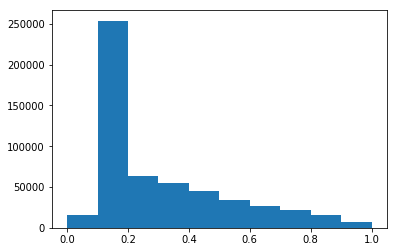

In [6]:
plt.hist(j_df[j_df['target']!=0]['target'])
plt.show()

This looks pretty nice, lets get some basic statistics

In [7]:
j_df[j_df['target']!=0]['target'].describe()

count    540110.000000
mean          0.344251
std           0.216199
min           0.000460
25%           0.166667
50%           0.206897
75%           0.500000
max           1.000000
Name: target, dtype: float64

**Some large takeaways here:**
1.  We have 540,110 toxic comments
2.  Our mean toxic comment value is 0.344251
3.  Clearly right skewed
4.  75% of our values are actually LESS than 0.50

Pretty interesting stuff off the bat.  I think point #4 is pretty interesting.  We have a pretty nice histogram, but let's increase our # of bins and see what happens, because the bin from 0.10 to 0.20 is very high.  Let's see if increasing the # of bins breaks up the 0.10 to 0.20 bin in hopes that we can better understand it.

## Excluding 0's, increasing bins

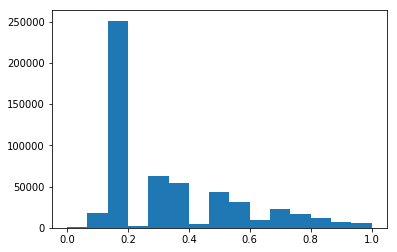

In [8]:
plt.hist(j_df[j_df['target']!=0]['target'], 15)
plt.show()

Okay, we broke up the 0.10 to 0.20 bin a bit, but not very much.  Let's increase the # of bins a bit more (also note some interesting stuff happening with the rest of the bins.

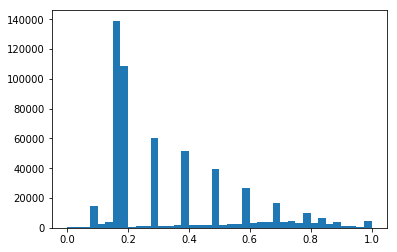

In [9]:
plt.hist(j_df[j_df['target']!=0]['target'], 40)
plt.show()

Okay, clearly some interesting stuff going on here, let's really bump up the # of bins.

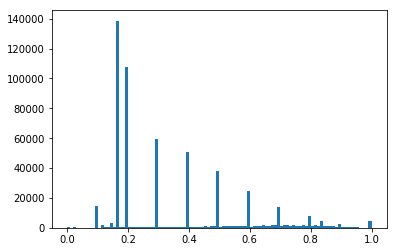

In [10]:
plt.hist(j_df[j_df['target']!=0]['target'], 100)
plt.show()

So we have some very common values, and they're distances apart from each other are very similar.  Let's dial in.  Let's pick a segment, and focus on the data within that segement, and hopefully this will lead to some insights as to why the data has this interesting structure.  Let's look at the 0.10 to 0.20 bin, since that's where most of the data lies.

# 0.10 to 0.20 Bin Deep Dive

In [11]:
print(j_df[(j_df['target']!=0) & (j_df['target']>=0.10) & (j_df['target']<=0.20)]['target'].describe())
print(stats.mode(j_df[(j_df['target']!=0) & (j_df['target']>=0.10) & (j_df['target']<=0.20)]['target']))

count    268451.000000
mean          0.175571
std           0.025405
min           0.100000
25%           0.166667
50%           0.166667
75%           0.200000
max           0.200000
Name: target, dtype: float64
ModeResult(mode=array([0.16666667]), count=array([138501]))


So seems like the most common value is 0.166667 which is equal to 1/6.  Let's take a look at a sample where the target is 1/6.

In [12]:
j_df[(j_df['target']!=0) & (j_df['target']==1/6)].head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
39,239625,0.166667,Pity the menu lost so much vegan food! The Mas...,0.0,0.0,0.000000,0.000000,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-13 22:44:39.842494+00,6,NaN,26675,approved,0,0,0,0,0,0.0,0,6
44,239632,0.166667,YET ANOTHER BARACK OBAMA LIBERAL MEDIA CONSPIR...,0.0,0.0,0.000000,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-13 23:16:38.456058+00,6,NaN,26795,rejected,0,0,0,0,0,0.0,4,6
65,239665,0.166667,This is certainly not good journalism by any s...,0.0,0.0,0.000000,0.166667,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-14 01:36:07.726162+00,6,NaN,26655,approved,0,0,0,1,0,0.0,0,6
75,239678,0.166667,To anyone reading this article. That's me and ...,0.0,0.0,0.000000,0.166667,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-14 02:26:04.500069+00,6,NaN,26654,approved,0,0,0,2,0,0.0,0,6
89,239707,0.166667,"I saw @christa_m mention this a little below, ...",0.0,0.0,0.166667,0.166667,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-14 10:49:35.233971+00,6,NaN,26795,approved,0,0,0,1,0,0.0,0,6


So according to the documentation *"We recognize that toxicity and identity can be subjective, so we collect labels from up to 10 people per comment, to capture a range of opinions."*  Again, they say *"**up to** 10 people per comment"*.  I interpret this to mean that they might not always take 10, in some cases they might take 9 or 8 or 7 or 6 or 5, etc.  

In this case it seems there were 6 annotators and only 1 of them found the comment to be toxic.

Let's learn a bit more about # of annotators...

In [13]:
print("Number of records where toxicity_annotator_count is 1: {}".format(len(j_df[(j_df['toxicity_annotator_count']==1)])))
print("Most common # of annotators:")
print(j_df['toxicity_annotator_count'].value_counts().head())
print("Most annotators: ", max(j_df['toxicity_annotator_count']))

Number of records where toxicity_annotator_count is 1: 0
Most common # of annotators:
4     1185412
10     262216
6      195839
5       76341
80       8537
Name: toxicity_annotator_count, dtype: int64
Most annotators:  4936


So it looks like 6 annotators is very common, which makes sense.

Makes me think... what does this look like for the extreme cases of toxic=1?

In [14]:
j_df[(j_df['target']!=0) & (j_df['target']==1.0)]['toxicity_annotator_count'].value_counts().head(1000)

4     3016
6      675
5      370
10     297
7       12
9        7
42       3
59       2
39       2
8        2
50       2
29       1
12       1
32       1
36       1
44       1
48       1
60       1
47       1
41       1
49       1
43       1
51       1
30       1
34       1
46       1
11       1
31       1
53       1
Name: toxicity_annotator_count, dtype: int64

So most have a low count which makes sense, and then we have some records with a HUGE number of annotators in agreement.

**Seems like maybe we should we be weighting records by # of annotators?  Seems like # of annotators gives us a level of credibility here.**

Okay, let's look at rows with toxic value of 1 and toxicity_annotator_count=4 ...

In [15]:
j_df[(j_df['target']!=0) & (j_df['target']==1.0) & (j_df['toxicity_annotator_count']==4)].head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
714,240961,1.0,Where do you get the Sour Grapes to say this i...,0.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-27 08:43:16.933783+00,6,NaN,34105,rejected,0,0,0,0,0,0.0,0,4
767,241026,1.0,Dear world:\nJust a reminder that none of thes...,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-28 01:06:17.854008+00,6,NaN,34702,approved,0,0,0,8,0,0.0,0,4
2551,244199,1.0,The Liars Anonymous meeting today will be at 4...,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-02-15 23:38:22.916243+00,13,NaN,38898,approved,0,0,0,0,0,0.0,0,4
3406,245354,1.0,"Marlene Pearson, do you really think Trump or ...",0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-02-21 16:45:22.387105+00,13,NaN,40324,approved,0,0,0,0,0,0.0,0,4
3431,245384,1.0,these non compliant dispensary owners are grin...,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-02-21 19:00:03.677828+00,13,NaN,40605,approved,0,0,0,0,0,0.0,0,4


Hmm...let's look through some comments..

In [16]:
pd.set_option('display.max_colwidth', -1)
j_df[(j_df['target']!=0) & (j_df['target']==1.0) & (j_df['toxicity_annotator_count']==4)]['comment_text'].head(40)

714      Where do you get the Sour Grapes to say this is a Bernie person?  Based on how Bernie does not allow this crap to go on where do you get off with the accusation?                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

This one seems interesting ...

In [17]:
j_df[(j_df['target']!=0) & (j_df['target']==1.0) & (j_df['toxicity_annotator_count']==4)]['comment_text'].iloc[33]

'I didn\'t mean to "like" my own comment  (darn computers).'

This comment doesn't seem overly toxic to me, yet 4 people agreed that this was toxic.  The rest of the comments seem pretty toxic with a handful that I would made argue are more boarderline toxic vs. a hard 1.0.  

This does bring up an interesting idea though, what if we compared the 1.0's to the 0's and looked that the comments that were most similar to eachother?  I'm just wondering how some of our most toxic comments compare to our non-toxic comments ..

# Comparing 1.0's to 0's

So what we want to do is take a toxic comment, and find the most similar non-toxic comment

We found an article that might be able to help us out here:  https://www.datacamp.com/community/tutorials/fuzzy-string-python

Let's pick a toxic string we want to use ...

In [22]:
print("Number of annotators:")
print(j_df[(j_df['target']!=0) & (j_df['target']==1.0)]['toxicity_annotator_count'].iloc[16])
print("Comment:")
print(j_df[(j_df['target']!=0) & (j_df['target']==1.0)]['comment_text'].iloc[16])

Number of annotators:
4
Comment:
And a major part of the problem is the lawyers waiting to blame these jerks conduct on their parents or schools any thing will work for a lawyer
Long as a lawyer gets paid anything goes


Let's try this one..

In [19]:
my_string = j_df[(j_df['target']!=0) & (j_df['target']==1.0)]['comment_text'].iloc[16]

def my_str_compare(x):
    return fuzz.token_sort_ratio(x,my_string)

jdf0 = j_df[j_df['target']==0]
jdf0['distance2mys1'] = jdf0['comment_text'].apply(my_str_compare)
jdf0.sort_values(by=['distance2mys1'], ascending=False).head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,distance2mys1
308715,620177,0.0,Actually this may not be a bad thing. Court is just where we want these guys. As long as the lawyers for the state represent the state and not the legislators.,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-11-22 19:51:12.456503+00,21,NaN,152542,approved,0,0,0,1,0,0.0,0,4,65
1491088,5945049,0.0,"The need to call this the Lawyer Enrichment Act. Or No Lawyer Left Behind. How dare people settle their cases without a lawyer getting paid for it? With, of course, the taxpayers paying.",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-09-13 13:15:45.530015+00,102,NaN,377168,approved,2,0,0,3,0,0.0,0,4,61
1122195,5487176,0.0,"For one thing, there is no such thing as Canada's 'first lady'\n\nPart of the problem is that Ms gregoire is unaware of this....",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,2017-06-27 20:01:07.792812+00,54,5486501.0,348818,approved,2,0,1,5,0,0.0,10,4,59
1481380,5933052,0.0,"They cite her as the province's first female lawyer, and not an example of any of the things you are trying to discuss. They're correct, and you're wildly off topic. Anything to get in an attack on SJWs past or present though, amirite?",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-11 15:19:26.458988+00,54,5932144.0,376312,approved,0,0,0,4,0,0.0,10,4,59
125405,395350,0.0,A lawyers best friends is the opposing attorney. They are able to bill more hours per contested fact.\nIn this case there will be four sets of attorneys who will make and lose money. What a laugh.,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-21 03:00:52.852095+00,13,NaN,141894,approved,0,0,0,1,0,0.0,0,6,59


Wow, this is pretty damn cool.  Few things I take away here..
1.  Notice that the toxic comment uses an expletive 'jerks' where the non-toxic comments don't include expletives, but the sentences are carzy similar.  I think you could use this as evidence to build a case regarding why just a logistic regression using TF-IDF works fairly well.
2.  The most toxic part of our toxic comment is *'Long as a lawyer gets paid anything goes*' because it's taking a shot at lawyers.  But notice this non-toxic comment *'In this case there will be four sets of attorneys who will make and lose money. What a laugh.'*  This also takes a shot at lawyers.  How would the NN tell these apart if it wasn't for the word 'jerks'? 

I think this give me 3 thoughts:
1.  Seems like using the additional tags to train some models for specific types of toxic comments and then finding a way to blend them could prove powerful, or even using all the tags in 1 model.
2.  Including a "bag of words" type model in an ensemble could really prove helpful
3.  TWIML has a great episode with David Ferrucci who goes over General AI and what it would take to get a G-AI.  I think there is something to be said here about teaching your AI system how to recognize different ideas and then how to combine those ideas.  This really just supports item #2, but what if you tried creating your own labels on ideas like sarcasm, or mockery, or taunting.  A lot of the additional tags revolve around social identities, but what about methods of communication?  Obviously you can't create at lot of your own tags, but maybe you could use BERT on your low number of tagged observations.  Or maybe you could try Google Drybell.  And, I think it's important to focus on concepts that seem like the NN would possibly choke on.  

 - https://twimlai.com/twiml-talk-268-are-we-being-honest-about-how-difficult-ai-really-is-with-david-ferrucci/
 - https://github.com/google-research/bert
 - https://ai.googleblog.com/2019/03/harnessing-organizational-knowledge-for.html
 
 What are some other ways we can get our AI to recognize complex ideas and concepts?

let's try another one ...

In [20]:
my_string = j_df[(j_df['target']!=0) & (j_df['target']==1.0)]['comment_text'].iloc[0]
print("Toxic string we're going to compare: {}".format(my_string))

def my_str_compare(x):
    return fuzz.token_sort_ratio(x,my_string)

jdf0 = j_df[j_df['target']==0]
jdf0['distance2mys1'] = jdf0['comment_text'].apply(my_str_compare)
print("Showing top 5 similar non-toxic comments:")
jdf0.sort_values(by=['distance2mys1'], ascending=False).head()

Toxic string we're going to compare: Where do you get the Sour Grapes to say this is a Bernie person?  Based on how Bernie does not allow this crap to go on where do you get off with the accusation?


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Showing top 5 similar non-toxic comments:


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,distance2mys1
1195285,5576626,0.0,"Those of us with basic reading skill have. I've asked you before, let's do it again. Where does it say that he ""beat up a panhandler""? Or do you have info that we don't?",0.0,0.0,0.0,0.166667,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-12 04:11:22.791996+00,102,5576608.0,354258,approved,1,0,0,1,0,0.0,0,6,61
949030,5279631,0.0,"Really. How do you know this ""for certain."" And what does it have to do with the Fatima cult's affiliation with the alt-right? (Nothing.)",0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-20 00:28:20.007282+00,53,5278413.0,333754,approved,0,0,0,0,0,0.0,0,4,61
120252,389129,0.0,"The oil and gas execs get paid big bucks. To get a good one, you have to offer a big salary.\nHowever, I don't think Meyer is worth this salary.",0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-07-15 17:08:04.496116+00,21,388939.0,141467,approved,0,0,0,0,0,0.0,6,4,61
859058,5171447,0.0,"I don't get this. You asked me to comment on two other articles, when the only one I've read is this one! Come on, DM, please get your act together.",0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-04-24 13:25:31.455158+00,100,NaN,329166,approved,0,0,0,0,0,0.0,0,4,61
1369256,5791202,0.0,"We dont pay taxes, you do\nWe get benefits, housing, and some dope new park improvements\nYou get a mortgage and more taxes\nWhose town do you think this is?\nThis is our town baby!",0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-08-17 23:35:18.582176+00,21,5790108.0,367441,approved,1,1,0,0,0,0.0,0,4,61


I would almost mark these as aggresively inquisitive.

Another idea ..

1.  What if you took each toxic comment as it's own concept?  So this comment actually captures 'aggresively inquisitive' pretty well.  You could exclude this observation from the dataset, then score the entire dataset using fuzz, then you could pick a threshold and 'if similarity>theshold then 1 else 0', then use that as a target for a new neural network.  You could create bunch of models using this technique and then use the StackNet k-fold method or just a hold-out set to create a meta learner.

let's try 1 more... a super confident toxic comment...

In [21]:
my_string = j_df[(j_df['target']!=0) & (j_df['target']==1.0) & (j_df['toxicity_annotator_count']==53)]['comment_text'].iloc[0]
print("Toxic string we're going to compare: {}".format(my_string))

def my_str_compare(x):
    return fuzz.token_sort_ratio(x,my_string)

jdf0 = j_df[j_df['target']==0]
jdf0['distance2mys1'] = jdf0['comment_text'].apply(my_str_compare)
print("Showing top 5 similar non-toxic comments:")
jdf0.sort_values(by=['distance2mys1'], ascending=False).head()

Toxic string we're going to compare: You're a fucking twat.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Showing top 5 similar non-toxic comments:


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,distance2mys1
736351,5022587,0.0,A fun read - thank you.,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-18 16:46:58.310646+00,54,NaN,319715,approved,0,1,0,0,1,0.0,0,4,73
284260,590305,0.0,"Well, you're arguing.",0.0,0.0,0.0,0.0,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-11-10 18:52:11.948857+00,21,589827.0,151245,approved,0,0,0,1,0,0.0,0,6,70
1502319,5959344,0.0,You sure he was joking?,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-09-15 16:27:42.655194+00,102,5958786.0,378126,approved,0,0,0,1,2,0.0,0,4,70
961997,5295032,0.0,What are you smoking?,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-24 03:17:31.029503+00,54,5295019.0,336977,approved,1,0,0,2,0,0.0,0,4,68
912898,5236692,0.0,What are you smoking!?,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-10 02:53:39.888124+00,54,5228970.0,332706,approved,0,0,0,0,0,0.0,0,4,68


Once I realized the comment we're comparing was "You're a fucking twat." I honestly didn't think we'd find any compelling comments, but I think we did.  "What are you smoking?" seems pretty toxic and aggressive to me ... I think weighting by # of annotators is looking pretty compelling because "What are you smoking?".  Maybe if "What are you smoking?" had received more annotators it would have ended up with a higher toxicity score?  

Unfortunately 1,185,412 comments have 4 annotators, which is a large chunk of the pie.  So weighting by # of annotators could help a bit, but I think trying to draw out more complex concepts could be more helpful in the end.

# Main Summary + Takeaways

1.  We have 540,110 toxic comments
2.  Our mean toxic comment value is 0.344251
3.  Clearly right skewed
4.  75% of our values are actually LESS than 0.50
5.  Including a 'bag of words' type model in an emsemble could give model lift
6.  Maybe we should be weighting records by # of annotators?
7.  Complex social concepts like mockery and being aggresively inquisitive could trip up your NN's
8.  Model blending by building models on various concepts could prove helpful to separate toxic from non-toxic comments especially when the toxic and non-toxic comments are overly similar.  (Or if you can build all of this into 1 model, that's something too).
9.  I think there is something to be said about the ideas on trying to capture many complex concepts, and the success of many public kernels using all targets (1 ex. https://www.kaggle.com/thousandvoices/simple-lstm)

# Final Comments

Please comment and let me know your ideas and thoughts
* Does this entire thread seem like garbage?  **If so, why? ** 
* Is thie thread any good?  **If so, why?**
* What could I do to improve this thread if anything?

Thanks everyone!